In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyod.models.auto_encoder import AutoEncoder

normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File("datasets/transients_cleaned_padded.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49666, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49666):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]
X_test_relay          = dataset_relay[47500:]

scalerMinMax.fit(X_train)
X_train_scaled_minmax       = scalerMinMax.transform(X_train)
X_test_norm_scaled_minmax   = scalerMinMax.transform(X_test_normal)
X_test_relay_scaled_minmax  = scalerMinMax.transform(X_test_relay)

scalerStandard.fit(X_train)
X_train_scaled_standard        = scalerStandard.transform(X_train)
X_test_norm_scaled_standard    = scalerStandard.transform(X_test_normal)
X_test_relay_scaled_standard   = scalerStandard.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled_minmax = np.vstack((X_test_norm_scaled_minmax, X_test_relay_scaled_minmax))
X_test_combined_scaled_standard = np.vstack((X_test_norm_scaled_standard, X_test_relay_scaled_standard))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

Training: 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


neuron (64, 32)
dropout 0.1
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.80      0.04      0.08      2166

    accuracy                           0.52      4332
   macro avg       0.66      0.52      0.38      4332
weighted avg       0.66      0.52      0.38      4332



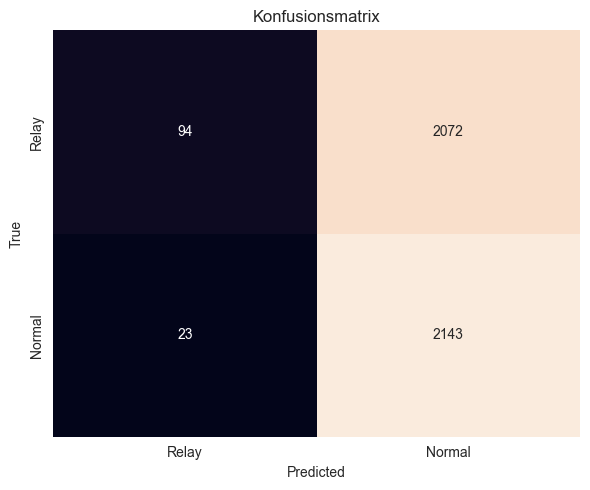

Training: 100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


neuron (64, 32)
dropout 0.1
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.52      0.99      0.68      2166
       Relay       0.88      0.07      0.14      2166

    accuracy                           0.53      4332
   macro avg       0.70      0.53      0.41      4332
weighted avg       0.70      0.53      0.41      4332



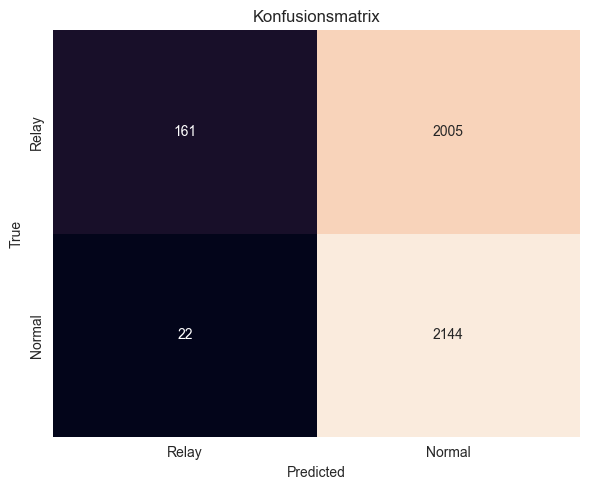

Training: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


neuron (64, 32)
dropout 0.1
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.87      0.05      0.10      2166

    accuracy                           0.52      4332
   macro avg       0.69      0.52      0.38      4332
weighted avg       0.69      0.52      0.38      4332



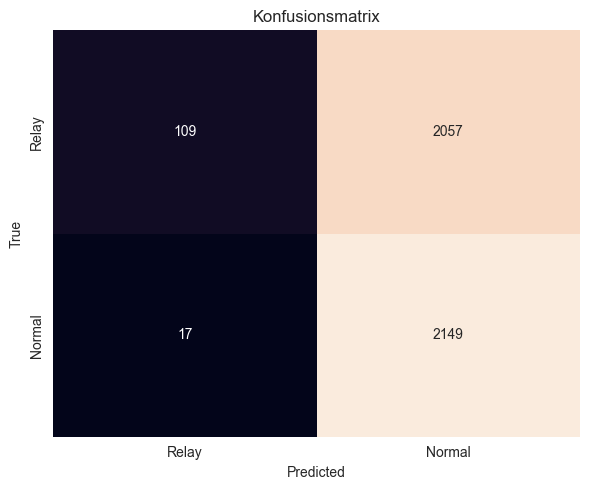

Training: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


neuron (64, 32)
dropout 0.2
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.86      0.05      0.09      2166

    accuracy                           0.52      4332
   macro avg       0.68      0.52      0.38      4332
weighted avg       0.68      0.52      0.38      4332



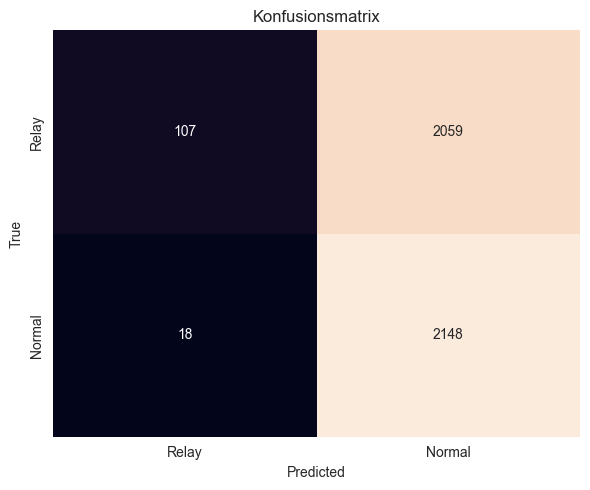

Training: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


neuron (64, 32)
dropout 0.2
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.52      0.99      0.68      2166
       Relay       0.88      0.07      0.13      2166

    accuracy                           0.53      4332
   macro avg       0.70      0.53      0.40      4332
weighted avg       0.70      0.53      0.40      4332



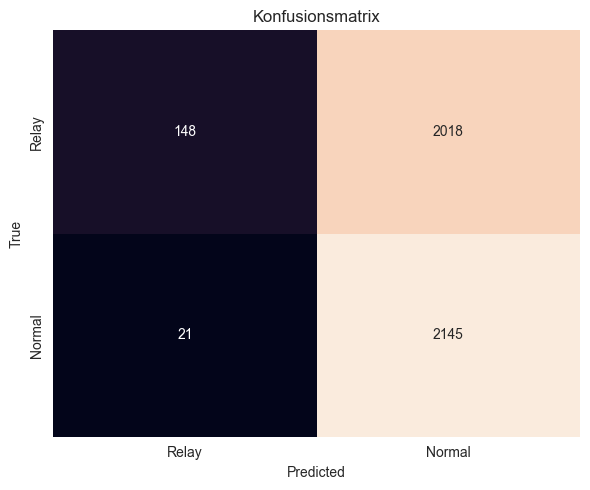

Training: 100%|██████████| 50/50 [01:44<00:00,  2.10s/it]


neuron (64, 32)
dropout 0.2
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.86      0.05      0.10      2166

    accuracy                           0.52      4332
   macro avg       0.68      0.52      0.39      4332
weighted avg       0.68      0.52      0.39      4332



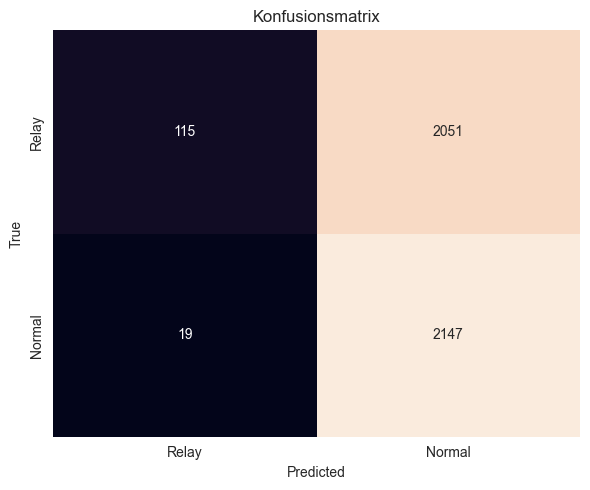

Training: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


neuron (64, 32)
dropout 0.3
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.83      0.04      0.08      2166

    accuracy                           0.52      4332
   macro avg       0.67      0.52      0.38      4332
weighted avg       0.67      0.52      0.38      4332



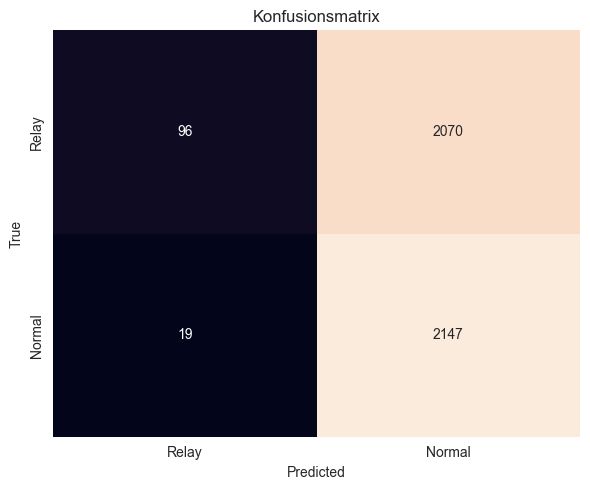

Training:  57%|█████▋    | 57/100 [01:57<01:28,  2.07s/it]


KeyboardInterrupt: 

In [2]:
# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for n in {(64, 32), (128, 64), (256, 128)}:
    for d in {0.1, 0.2, 0.3}:
        for e in {10, 50, 100}:
            clf = AutoEncoder(contamination=0.01, hidden_neuron_list=n, dropout_rate=d, preprocessing=False, epoch_num=e)
            clf.fit(X_train)

            # pyod.predict: 0 = inlier, 1 = outlier
            y_pred = clf.predict(X_test_combined)

            # cm und report
            cm = confusion_matrix(y_true, y_pred, labels=[1,0])
            print(f"neuron {n}")
            print(f"dropout {d}")
            print(f"epoch num {e}")
            print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

            # plot
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt="d",
                        xticklabels=["Relay","Normal"],
                        yticklabels=["Relay","Normal"],
                        cbar=False)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title("Konfusionsmatrix")
            plt.tight_layout()
            plt.show()

Training: 100%|██████████| 10/10 [00:25<00:00,  2.60s/it]


neuron (64, 32)
dropout 0.1
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.83      0.06      0.11      2166

    accuracy                           0.52      4332
   macro avg       0.67      0.52      0.39      4332
weighted avg       0.67      0.52      0.39      4332



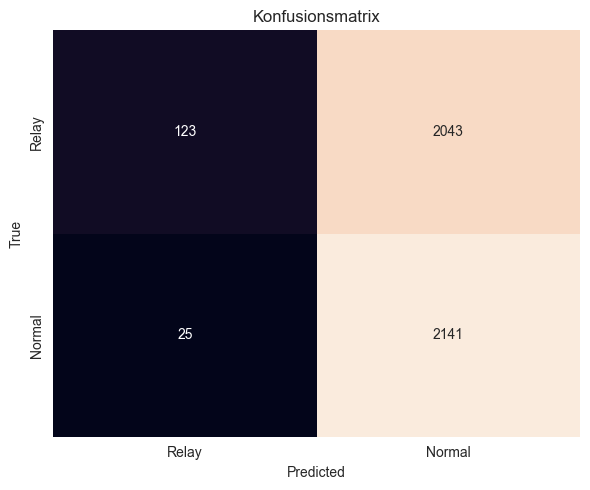

Training: 100%|██████████| 100/100 [03:44<00:00,  2.24s/it]


neuron (64, 32)
dropout 0.1
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.52      0.99      0.68      2166
       Relay       0.88      0.07      0.14      2166

    accuracy                           0.53      4332
   macro avg       0.70      0.53      0.41      4332
weighted avg       0.70      0.53      0.41      4332



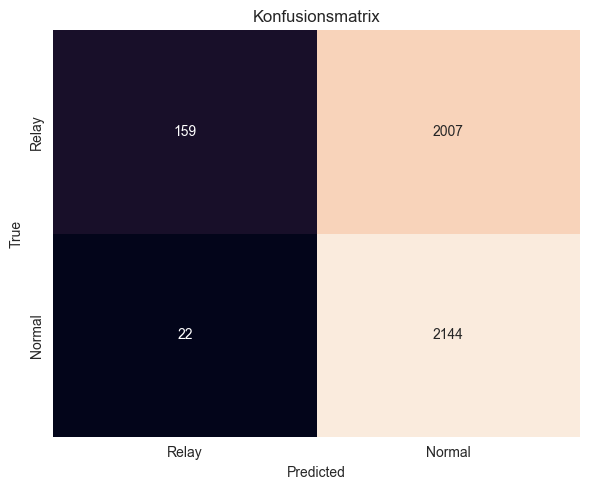

Training: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


neuron (64, 32)
dropout 0.1
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.68      2166
       Relay       0.87      0.06      0.12      2166

    accuracy                           0.53      4332
   macro avg       0.69      0.53      0.40      4332
weighted avg       0.69      0.53      0.40      4332



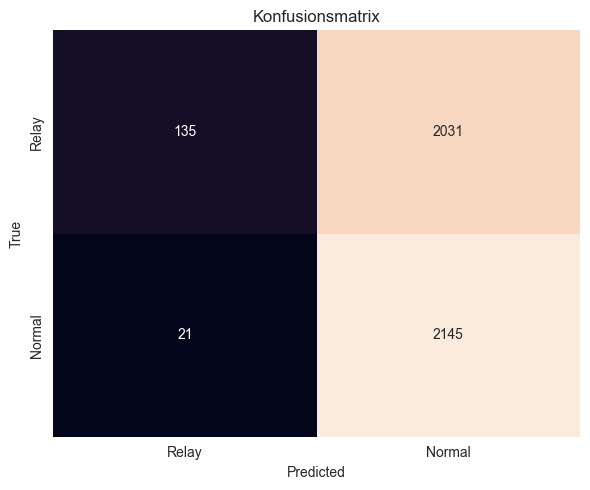

Training: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


neuron (64, 32)
dropout 0.2
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.99      0.67      2166
       Relay       0.84      0.05      0.09      2166

    accuracy                           0.52      4332
   macro avg       0.68      0.52      0.38      4332
weighted avg       0.68      0.52      0.38      4332



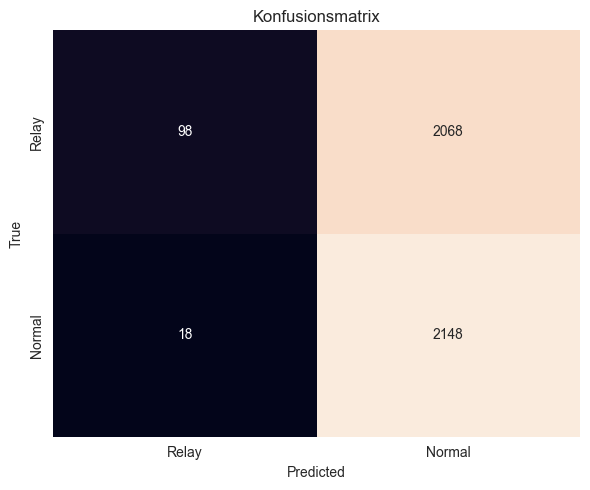

Training:  46%|████▌     | 46/100 [01:27<01:42,  1.91s/it]


KeyboardInterrupt: 

In [3]:
# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for n in {(64, 32), (128, 64), (256, 128)}:
    for d in {0.1, 0.2, 0.3}:
        for e in {10, 50, 100}:
            clf = AutoEncoder(contamination=0.01, hidden_neuron_list=n, dropout_rate=d, preprocessing=False, epoch_num=e)
            clf.fit(X_train_scaled_standard)

            # pyod.predict: 0 = inlier, 1 = outlier
            y_pred = clf.predict(X_test_combined_scaled_standard)

            # cm und report
            cm = confusion_matrix(y_true, y_pred, labels=[1,0])
            print(f"neuron {n}")
            print(f"dropout {d}")
            print(f"epoch num {e}")
            print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

            # plot
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt="d",
                        xticklabels=["Relay","Normal"],
                        yticklabels=["Relay","Normal"],
                        cbar=False)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title("Konfusionsmatrix")
            plt.tight_layout()
            plt.show()

In [ ]:
# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for n in {(64, 32), (128, 64), (256, 128)}:
    for d in {0.1, 0.2, 0.3}:
        for e in {10, 50, 100}:
            clf = AutoEncoder(contamination=0.01, hidden_neuron_list=n, dropout_rate=d, preprocessing=False, epoch_num=e)
            clf.fit(X_train_scaled_minmax)

            # pyod.predict: 0 = inlier, 1 = outlier
            y_pred = clf.predict(X_test_combined_scaled_minmax)

            # cm und report
            cm = confusion_matrix(y_true, y_pred, labels=[1,0])
            print(f"neuron {n}")
            print(f"dropout {d}")
            print(f"epoch num {e}")
            print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

            # plot
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt="d",
                        xticklabels=["Relay","Normal"],
                        yticklabels=["Relay","Normal"],
                        cbar=False)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title("Konfusionsmatrix")
            plt.tight_layout()
            plt.show()

            """MINMAX SCALER FEHLT DAMIT WEITERMACHEN"""